Please answer completely all four required questions (250 Points).

### Question 1: Load (50 Points)

- Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found as transactions.txt (above attached)

- Please describe the structure of the data. Number of records and fields in each record?

- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

In [3]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [5]:
num_records = len(df)
print(f"Number of records: {num_records:,}")

Number of records: 786,363


In [6]:
num_fields = len(df.columns)
print(f"Number of fields in each record: {num_fields}")
print(f"Fields: {', '.join(df.columns)}")

Number of fields in each record: 29
Fields: accountNumber, customerId, creditLimit, availableMoney, transactionDateTime, transactionAmount, merchantName, acqCountry, merchantCountryCode, posEntryMode, posConditionCode, merchantCategoryCode, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, transactionType, echoBuffer, currentBalance, merchantCity, merchantState, merchantZip, cardPresent, posOnPremises, recurringAuthInd, expirationDateKeyInMatch, isFraud


In [7]:
# Statistics
print("\nSummary statistics:")
for column in df.columns:
    print(f"\nField: {column}")
    # Null values
    null_count = df[column].isnull().sum()
    print(f"  Null count: {null_count}")
    
    # Unique values
    unique_count = df[column].nunique()
    print(f"  Unique values: {unique_count}")
    
    # Min and max
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"  Min: {df[column].min()}")
        print(f"  Max: {df[column].max()}")
        print(f"  Mean: {df[column].mean()}")
    
    # If its a string field then min and max length
    elif pd.api.types.is_string_dtype(df[column]):
        if null_count < len(df): 
            # Length
            lengths = df[column].dropna().astype(str).apply(len)
            if not lengths.empty:
                print(f"  Min length: {lengths.min()}")
                print(f"  Max length: {lengths.max()}")
    

    if unique_count < 20 and unique_count > 0:
        sample_values = df[column].dropna().unique()[:5]  # Get first 5 unique values
        print(f"  Sample values: {', '.join(map(str, sample_values))}")



Summary statistics:

Field: accountNumber
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: customerId
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: creditLimit
  Null count: 0
  Unique values: 10
  Min: 250
  Max: 50000
  Mean: 10759.464458526152
  Sample values: 5000, 2500, 50000, 15000, 10000

Field: availableMoney
  Null count: 0
  Unique values: 521915
  Min: -1005.63
  Max: 50000.0
  Mean: 6250.725369288736

Field: transactionDateTime
  Null count: 0
  Unique values: 776637
  Min length: 19
  Max length: 19

Field: transactionAmount
  Null count: 0
  Unique values: 66038
  Min: 0.0
  Max: 2011.54
  Mean: 136.98579095150708

Field: merchantName
  Null count: 0
  Unique values: 2490
  Min length: 4
  Max length: 30

Field: acqCountry
  Null count: 0
  Unique values: 5
  Min length: 0
  Max length: 3
  Sample values: US, , CAN, MEX, PR

Field: merchantCountryCode
  Nu

### Question 2: Plot (25 Points)

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

- Report any structure you find and any hypotheses you have about that structure.

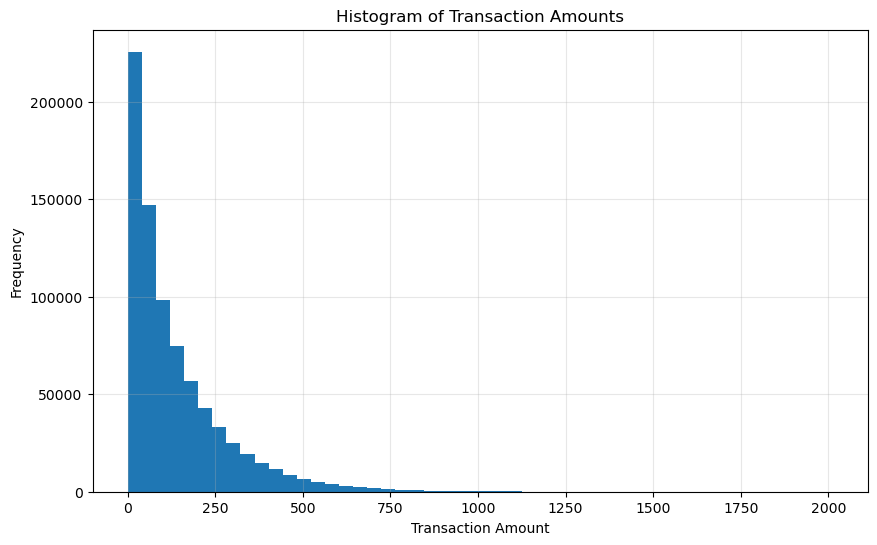

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df['transactionAmount'], bins=50)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

_The histogram shows a strong positive skew with a high concentration of transactions at values under $250 and a long tail extending to around $2,000._

_The frequency of transactions declimes exponentially as the transaction amount increases. The highest frequency bar is at the lowest end, indicating that very small transactions are the most common. There appears to be a primary concentration zone under $250, and then a more gradual decline in frequency for transactions between $250-750. Transactions above $750 are relatively rare, making up only a small percentage of the overall dataset._

_The distribution represents different categories of transactions, with everyday small purchases dominating the lower end and occasional larger purchases forming the tail. This pattern is consistent with typical consumer spending behavior. The gradual decrease in frequency might indicate consumer behavior changes like more deliberation for purchases above certain amounts._

_If this data comes from a specific business, the distribution suggests a business model focused on high-volume, lower-value transactions. The extreme values in the tail might be worth investigating for potential anomalies. It can be applied to the data a logarithmic transformation to normalize the distribution._

### Question 3: Data Wrangling - Duplicate Transactions (75 Points)

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

- Can you programmatically identify reversed and multi-swipe transactions?

- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts).

- Did you find anything interesting about either kind of transaction?


### Question 4: Model (100 Points)

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

- Each of the transactions in the dataset has a field called isFraud. Please build a machine learning model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

- Provide an estimate of performance using an appropriate sample, and show your work.

- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time).